[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ZuchniakK/CryptoDataProcessing/blob/main/5_sample_generator.ipynb)

### Having prepared a dataset, we can prepare an appropriate generator of examples on its basis. This notebook focuses on the aspect of generating data in the form of batch examples and verifying that everything works correctly.

In [1]:
import pickle
from functools import partial
from math import gcd
from time import monotonic

import matplotlib.colors as mcolors
import matplotlib.patches as mpatch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from crypto_data import OHLCDataSet
from matplotlib.patches import Ellipse

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [8, 8]

In [3]:
def shift(xs, n):
    e = np.empty_like(xs)
    if n > 0:
        e[:n] = np.nan
        e[n:] = xs[:-n]
    elif n == 0:
        e = xs
    else:
        e[n:] = np.nan
        e[:n] = xs[-n:]
    return e


def pct_change(array, columns_order, seq_len, base_column, future_column, future_steps):
    base = shift(array[:, np.where(columns_order == base_column)[0][0]], -seq_len - 1)
    future = array[:, np.where(columns_order == future_column)[0][0]]
    future = shift(future, -future_steps - seq_len - 1)
    pct_change = future / base - 1

    return pct_change, future_steps

In [4]:
class DataGenerator:
    def __init__(
        self,
        dataset=None,
        metadata=None,
        arrays=None,
        y_funcs=None,
        val_test_split=0.7,
        y_standarize=True,
    ):
        if dataset is not None:
            with open(dataset, "rb") as file:
                dataset = pickle.load(file)
                self.metadata = dataset.get_metadata()
                self.x = dataset.get_arrays()
        else:
            if metadata is None or arrays is None:
                raise ValueError(
                    "metadata and arrays cant be None if dataset is not provided"
                )
            with open(metadata, "rb") as file:
                if metadata.endswith(".pkl"):
                    self.metadata = pickle.load(file)
                else:
                    self.metadata = json.load(file)
            arrays = np.load(arrays)
            self.x = [
                arrays[str(interval)] for interval in self.metadata["ohlc_intervals"]
            ]

        self.val_test_split = val_test_split
        self.y_standarize = y_standarize

        self.y_funcs = y_funcs
        self.max_len_y = 0
        self.y_names = []
        self.y = []
        self.y_mean = None
        self.y_std = None

        # get most important metadata for better readability
        self.ohlc_intervals = self.metadata["ohlc_intervals"]
        self.pairs = self.metadata["pairs"]
        self.columns_order = self.metadata["dataframe_stats"][self.ohlc_intervals[0]][
            "columns_order"
        ]
        self.dataset_seq_len = [
            self.metadata["dataset_seq_len"][interval]
            for interval in self.ohlc_intervals
        ]
        self.n_others = len(self.ohlc_intervals[1:])
        self.others_len = np.array([x.shape[1] for x in self.x[1:]])

        self.base_pairs_len = np.array(
            [
                self.metadata["dataframe_stats"][self.ohlc_intervals[0]]["pairs"][pair][
                    "lenghts"
                ][0]
                for pair in self.pairs
            ]
        )
        self.base_pairs_len = np.cumsum(self.base_pairs_len)
        self.base_pairs_len = np.insert(self.base_pairs_len, 0, 0)

        self.others_pairs_len = []
        for interval in self.ohlc_intervals[1:]:
            arr = np.array(
                [
                    self.metadata["dataframe_stats"][interval]["pairs"][pair]["lenghts"]
                    for pair in self.pairs
                ]
            )
            arr = np.cumsum(arr, axis=0)
            arr = arr.T
            arr = np.insert(arr, 0, 0, axis=1)
            self.others_pairs_len.append(arr)

        # calculate posible offsets values, usefull during sampling
        self.freq = []
        self.offsets = []
        for interval in self.ohlc_intervals[1:]:
            self.freq.append(interval // self.ohlc_intervals[0])
            offsets = [
                self.ohlc_intervals[0] * step
                for step in range(interval // self.ohlc_intervals[0])
            ]
            offsets = sorted(offsets, reverse=True)[:-1]
            offsets.insert(0, 0)
            self.offsets.append(np.array(offsets))
        self.freq = np.array(self.freq)

        # We can define any objective Y.
        # If Y is not given, the value of 'close' will be predicted for the next 5 time steps
        if self.y_funcs is None:
            column = "close"
            self.y_funcs = [
                (
                    f"pct_change_{i}",
                    partial(
                        pct_change,
                        base_column=column,
                        future_column=column,
                        future_steps=i,
                    ),
                )
                for i in range(1, 10)
            ]
        # the maximum number of steps forward for the predicted values.
        # It determines how many last samples will be dropped,
        # we have no information for them about the future values of the predicted feature.
        for name, func in self.y_funcs:
            array, max_len_y = func(
                self.x[0], self.columns_order, seq_len=self.dataset_seq_len[0]
            )
            self.y.append(array)
            self.y_names.append(name)
            self.max_len_y = max(self.max_len_y, max_len_y)
        self.y = np.stack(self.y, axis=1)

        (
            self.train_indices,
            self.val_indices,
            self.test_indices,
        ) = self._calculate_indices()

        if y_standarize:
            self.y_mean = self.y[self.train_indices].mean(axis=0)
            self.y_std = self.y[self.train_indices].std(axis=0)
            self.y = (self.y - self.y_mean) / self.y_std

    def _calculate_indices(self):
        # Arrays are concatenated, we need to carefully choose indexes from which the data will be sampled
        # so as not to select fragments containing data from 2 pairs.
        # numpy.lib.stride_tricks.as_strided is also used to sampling with memory efficient manner
        base_pair_lenghts = [
            v["lenghts"][0]
            for k, v in self.metadata["dataframe_stats"][self.ohlc_intervals[0]][
                "pairs"
            ].items()
        ]
        base_train_lenghts = [
            v["train_steps"][0]
            for k, v in self.metadata["dataframe_stats"][self.ohlc_intervals[0]][
                "pairs"
            ].items()
        ]
        seq_len = self.dataset_seq_len[0]
        n_pairs = len(base_pair_lenghts)

        forbidden_indices = []
        for i in range(n_pairs):
            # remove indexes with mixed pairs
            start_pos = sum(base_pair_lenghts[: i + 1]) - seq_len + 1
            forbidden = list(range(start_pos, start_pos + seq_len - 1))
            forbidden_indices.extend(forbidden)
            # remove indices that does not contain calculable y features
            forbidden = list(range(start_pos, start_pos - self.max_len_y - 1, -1))
            forbidden_indices.extend(forbidden)

        train_indices = []
        val_indices = []
        test_indices = []
        for i in range(n_pairs):
            start_pos = sum(base_pair_lenghts[:i])
            last_pos = base_pair_lenghts[i]
            train_indices.extend(
                list(range(start_pos, start_pos + base_train_lenghts[i] - seq_len + 1))
            )

            val_test_indices = list(
                range(
                    start_pos + base_train_lenghts[i] - seq_len + 1,
                    start_pos + last_pos,
                )
            )
            val_test_indices = [
                idx for idx in val_test_indices if idx not in forbidden_indices
            ]
            split_idx = int(len(val_test_indices) * self.val_test_split)
            val_indices.extend(val_test_indices[:split_idx])
            test_indices.extend(val_test_indices[split_idx:])
        train_indices = [idx for idx in train_indices if idx not in forbidden_indices]

        return np.array(train_indices), np.array(val_indices), np.array(test_indices)

    def get_generator(
        self,
        indices,
        batch_size=32,
        replace=False,
        feature_last=True,
        price_normalize=None,
        price_normalize_column=None,
        seed=None,
    ):

        base_seq_len = self.dataset_seq_len[0]
        base_window = np.lib.stride_tricks.sliding_window_view(
            self.x[0], base_seq_len, axis=0
        )
        other_windows = [
            np.lib.stride_tricks.sliding_window_view(
                x.reshape((x.shape[0] * x.shape[1], x.shape[2])), seq_len, axis=0
            )
            for x, seq_len in zip(self.x[1:], self.dataset_seq_len[1:])
        ]
        if feature_last:
            base_window = np.moveaxis(base_window, -1, -2)
            other_windows = [np.moveaxis(window, -1, -2) for window in other_windows]

        if price_normalize:
            if price_normalize not in [
                "pct_change",
                "max_pct_change",
                "last_pct_change",
            ]:
                raise ValueError(
                    "price_normalize can be: 'pct_change', 'max_pct_change' or 'last_pct_change'"
                )

            price_normalization_factors = np.array(
                [
                    self.metadata["dataframe_stats"][interval]["price_std"][
                        price_normalize_column
                    ][price_normalize]
                    for interval in self.ohlc_intervals
                ]
            )
            price_indices = [
                np.where(
                    np.isin(
                        self.metadata["dataframe_stats"][interval]["columns_order"],
                        self.metadata["price_col"] + self.metadata["pair_col"],
                    )
                )[0]
                for interval in self.ohlc_intervals
            ]

            price_normalize_indices = [
                np.where(
                    self.metadata["dataframe_stats"][interval]["columns_order"]
                    == price_normalize_column
                )[0][0]
                for interval in self.ohlc_intervals
            ]

        base_freqs = []
        base_values = []
        for i, pair in enumerate(self.pairs):
            base_first_timestamp = self.metadata["dataframe_stats"][
                self.ohlc_intervals[0]
            ]["pairs"][pair]["first_timestamps"][0]
            base_freq = base_first_timestamp.freq.nanos
            base_value = base_first_timestamp.value
            base_freqs.append(base_freq)
            base_values.append(base_value)
        base_freqs = np.array(base_freqs)
        base_values = np.array(base_values)

        other_freqs = []
        result = []
        for i, pair in enumerate(self.pairs):
            result.append([])
            other_freqs.append([])
            for interval in self.ohlc_intervals[1:]:
                timestamps = self.metadata["dataframe_stats"][interval]["pairs"][pair][
                    "first_timestamps"
                ]
                interval_freq = timestamps[0].freq.nanos
                other_freqs[i].append(interval_freq)
                timestamps = [t.value for t in timestamps]
                result[i].append(
                    [(t - base_freqs[i]) % interval_freq for t in timestamps]
                    + [
                        np.nan
                        for _ in range(
                            int(self.ohlc_intervals[-1] / self.ohlc_intervals[0])
                            - len(timestamps)
                        )
                    ]
                )
        result = np.array(result)
        other_freqs = np.array(other_freqs)

        while True:
            if seed is not None:
                np.random.seed(seed)
            selected = np.random.choice(indices, batch_size, replace=replace)
            x_batch = [base_window[selected]]

            ind = np.searchsorted(self.base_pairs_len, selected + 1) - 1
            reductor = self.base_pairs_len[ind]
            idx = selected - reductor

            mod = np.mod(
                np.repeat(
                    ((idx + self.dataset_seq_len[0]) * base_freqs[ind])[np.newaxis, :],
                    self.n_others,
                    axis=0,
                ).T,
                other_freqs[ind],
            )
            x = np.repeat(mod[:, :, np.newaxis], result.shape[-1], axis=-1)
            offset_id = np.where(result[ind] == x)[-1].reshape((-1, self.n_others)).T

            for i in range(self.n_others):
                offset = offset_id[i]
                new_idx = (
                    offset * self.others_len[i]
                    + idx // self.freq[i]
                    + self.others_pairs_len[i][offset, ind]
                )
                x_batch.append(other_windows[i][new_idx])

            if price_normalize:
                for i, x in enumerate(x_batch):
                    x[:, :, price_indices[i]] = (
                        (
                            x[:, :, price_indices[i]]
                            - x[
                                :,
                                -1,
                                price_normalize_indices[i],
                                np.newaxis,
                                np.newaxis,
                            ]
                        )
                        / x[:, -1, price_normalize_indices[i], np.newaxis, np.newaxis]
                        / price_normalization_factors[i]
                    )

            for x in x_batch:
                x[np.isnan(x)] = 0

            yield x_batch, self.y[selected]

    def get_train_generator(
        self,
        batch_size=32,
        replace=False,
        feature_last=True,
        price_normalize=None,
        price_normalize_column=None,
        seed=None,
    ):
        return self.get_generator(
            self.train_indices,
            batch_size=batch_size,
            replace=replace,
            feature_last=feature_last,
            price_normalize=price_normalize,
            price_normalize_column=price_normalize_column,
            seed=seed,
        )

    def get_val_generator(
        self,
        batch_size=32,
        replace=False,
        feature_last=True,
        price_normalize=None,
        price_normalize_column=None,
        seed=None,
    ):
        return self.get_generator(
            self.val_indices,
            batch_size=batch_size,
            replace=replace,
            feature_last=feature_last,
            price_normalize=price_normalize,
            price_normalize_column=price_normalize_column,
            seed=seed,
        )

    def get_test_generator(
        self,
        batch_size=32,
        replace=False,
        feature_last=True,
        price_normalize=None,
        price_normalize_column=None,
        seed=None,
    ):
        return self.get_generator(
            self.test_indices,
            batch_size=batch_size,
            replace=replace,
            feature_last=feature_last,
            price_normalize=price_normalize,
            price_normalize_column=price_normalize_column,
            seed=seed,
        )

The DataGenerator enables efficient sampling from a previously created dataset. Normalizes the data in relation to the price value from the last time step, thanks to which, regardless of the actual price value, our data has the characteristics of a normal distribution.

To initialize the DataGenerator object, you must provide a file containing metadata of the dataset and a file containing arrays (can be compressed) numpy.

You can also build a generator using a pickled instance of the class, but the class itself must be defined and this is a less memory efficient option, we load the entire class including its dataframes instead of just the numpy array we actually need.

In [5]:
data_generator = DataGenerator(metadata="metadata.pkl", arrays="arrays.npz")
# data_generator = DataGenerator(dataset = 'instance.pkl')

Checking whether all index juggling, whether individual time intervals overlap well, whether trading pairs are not mixed, etc., was tedious, so some things should be tested well to make sure that our generator will not return incorrectly processed data. So I defined a few tests that determine if our example generator works correctly, for example the last time step for the CLOSE feature will be the same regardless of the width of the time intervals

In [6]:
def lcm(a, b):
    return abs(a * b) // gcd(a, b)


class GeneratorTester:
    def __init__(self, data_generator):
        self.data_generator = data_generator
        self.metadata = data_generator.metadata
        self.ohlc_intervals = self.metadata["ohlc_intervals"]

    def test_ohlc_data(self, n=1000, batch_size=32):
        intervals = self.ohlc_intervals
        close_loc = [
            np.where(self.metadata["dataframe_stats"][i]["columns_order"] == "close")[
                0
            ][0]
            for i in self.ohlc_intervals
        ]
        open_loc = [
            np.where(self.metadata["dataframe_stats"][i]["columns_order"] == "open")[0][
                0
            ]
            for i in self.ohlc_intervals
        ]
        high_loc = [
            np.where(self.metadata["dataframe_stats"][i]["columns_order"] == "high")[0][
                0
            ]
            for i in self.ohlc_intervals
        ]
        low_loc = [
            np.where(self.metadata["dataframe_stats"][i]["columns_order"] == "low")[0][
                0
            ]
            for i in self.ohlc_intervals
        ]

        batch_time, test_time = 0, 0

        gen = self.data_generator.get_train_generator(
            price_normalize=False,
            batch_size=batch_size,
        )

        errors = {
            "open": 0,
            "high": 0,
            "low": 0,
            "close": 0,
        }

        for _ in range(n):
            tmp = monotonic()
            x_batch, y_batch = next(gen)
            batch_time += monotonic() - tmp
            tmp = monotonic()
            for i, interval_a in enumerate(intervals):
                for j, interval_b in enumerate(intervals[i + 1 :]):
                    close_a = x_batch[i][:, :, close_loc[i]]
                    close_b = x_batch[j + i + 1][:, :, close_loc[j + i + 1]]
                    errors["close"] += self.check_close(
                        interval_a, interval_b, close_a, close_b
                    )

                    open_a = x_batch[i][:, :, open_loc[i]]
                    open_b = x_batch[j + i + 1][:, :, open_loc[j + i + 1]]
                    errors["open"] += self.check_open(
                        interval_a, interval_b, open_a, open_b
                    )

                    high_a = x_batch[i][:, :, high_loc[i]]
                    high_b = x_batch[j + i + 1][:, :, high_loc[j + i + 1]]
                    errors["high"] += self.check_high(
                        interval_a, interval_b, high_a, high_b
                    )

                    low_a = x_batch[i][:, :, low_loc[i]]
                    low_b = x_batch[j + i + 1][:, :, low_loc[j + i + 1]]
                    errors["low"] += self.check_low(
                        interval_a, interval_b, low_a, low_b
                    )
            test_time += monotonic() - tmp

        print(
            f"batch size: {batch_size}, n tests: {n}, batch generation took: {batch_time}, testing took: {test_time}"
        )
        return errors

    @staticmethod
    def check_close(interval_a, interval_b, array_a, array_b, verbose=False):
        intervals_lcm = lcm(interval_a, interval_b)
        list_len = array_a.shape[1]

        counter_error = 0
        for idx in range(array_a.shape[0]):
            a = array_a[idx]
            b = array_b[idx]

            idxs_a = [
                -int(i * intervals_lcm / interval_a) - 1
                for i in range(list_len // (intervals_lcm // interval_a))
            ]
            idxs_b = [
                -int(i * intervals_lcm / interval_b) - 1
                for i in range(list_len // (intervals_lcm // interval_a))
            ]
            selected_a = a[idxs_a]
            selected_b = b[idxs_b]

            for i in range(len(idxs_a)):
                if selected_a[i] != selected_b[i]:
                    counter_error += 1
                    if verbose:
                        print("close error")
                        print(interval_a, interval_b, idx, a, b, selected_a, selected_b)
        return counter_error

    @staticmethod
    def check_open(interval_a, interval_b, array_a, array_b, verbose=False):
        intervals_lcm = lcm(interval_a, interval_b)
        list_len = array_a.shape[1]

        counter_error = 0
        for idx in range(array_a.shape[0]):
            a = array_a[idx]
            b = array_b[idx]

            offset_a = intervals_lcm // interval_a - 1
            offset_b = intervals_lcm // interval_b - 1
            idxs_a = [
                -int(i * intervals_lcm / interval_a) - 1 - offset_a
                for i in range(list_len // (intervals_lcm // interval_a))
            ]
            idxs_b = [
                -int(i * intervals_lcm / interval_b) - 1 - offset_b
                for i in range(list_len // (intervals_lcm // interval_a))
            ]
            selected_a = a[idxs_a]
            selected_b = b[idxs_b]

            for i in range(len(idxs_a)):
                if selected_a[i] != selected_b[i]:
                    counter_error += 1
                    if verbose:
                        print("open error")
                        print(interval_a, interval_b, idx, a, b, selected_a, selected_b)
        return counter_error

    @staticmethod
    def check_high(interval_a, interval_b, array_a, array_b, verbose=False):
        intervals_lcm = lcm(interval_a, interval_b)
        list_len = array_a.shape[1]

        for idx in range(array_a.shape[0]):
            a = array_a[idx]
            b = array_b[idx]

        idxs_a = [
            (
                list_len - int((i - 1) * intervals_lcm / interval_a),
                list_len - int(i * intervals_lcm / interval_a),
            )
            for i in range(1, list_len // (intervals_lcm // interval_a))
        ]
        idxs_b = [
            (
                list_len - int((i - 1) * intervals_lcm / interval_b),
                list_len - int(i * intervals_lcm / interval_b),
            )
            for i in range(1, list_len // (intervals_lcm // interval_a))
        ]
        selected_a = [list(a[start:stop]) for stop, start in idxs_a[::-1]]
        selected_b = [list(b[start:stop]) for stop, start in idxs_b[::-1]]

        counter_error = 0
        for i in range(len(idxs_a)):
            if max(selected_a[i]) != max(selected_b[i]):
                counter_error += 1
                if verbose:
                    print("high error")
                    print(interval_a, interval_b, idx, a, b, selected_a, selected_b)
        return counter_error

    @staticmethod
    def check_low(interval_a, interval_b, array_a, array_b, verbose=False):
        intervals_lcm = lcm(interval_a, interval_b)
        list_len = array_a.shape[1]

        for idx in range(array_a.shape[0]):
            a = array_a[idx]
            b = array_b[idx]

        idxs_a = [
            (
                list_len - int((i - 1) * intervals_lcm / interval_a),
                list_len - int(i * intervals_lcm / interval_a),
            )
            for i in range(1, list_len // (intervals_lcm // interval_a))
        ]
        idxs_b = [
            (
                list_len - int((i - 1) * intervals_lcm / interval_b),
                list_len - int(i * intervals_lcm / interval_b),
            )
            for i in range(1, list_len // (intervals_lcm // interval_a))
        ]
        selected_a = [list(a[start:stop]) for stop, start in idxs_a[::-1]]
        selected_b = [list(b[start:stop]) for stop, start in idxs_b[::-1]]

        counter_error = 0
        for i in range(len(idxs_a)):
            if min(selected_a[i]) != min(selected_b[i]):
                counter_error += 1
                if verbose:
                    print("low error")
                    print(interval_a, interval_b, idx, a, b, selected_a, selected_b)
        return counter_error

In [7]:
gt = GeneratorTester(data_generator)
errors = gt.test_ohlc_data(n=1000, batch_size=64)
print(f"errors: {errors}")

batch size: 64, n tests: 1000, batch generation took: 2.99801917210425, testing took: 3.1542898090301605
errors: {'open': 0, 'high': 0, 'low': 0, 'close': 0}


A visual check by drawing some graphs is of course also advisable

In [8]:
train_gen = data_generator.get_train_generator(
    price_normalize="pct_change", price_normalize_column="close", seed=123
)
val_gen = data_generator.get_val_generator(
    price_normalize="pct_change", price_normalize_column="close"
)
test_gen = data_generator.get_test_generator(
    price_normalize="pct_change", price_normalize_column="close", batch_size=128
)

In [9]:
x_batch_train, y_batch_train = next(train_gen)
x_batch_train[0].shape

(32, 30, 257)

We applied normalization by dividing by the closing price values ​​in the last time step. We then subtracted one from these values ​​and divided by the standard deviation. Thanks to this, the price closing value in the last time step itself has a value equal to 0, for all selected time intervals.

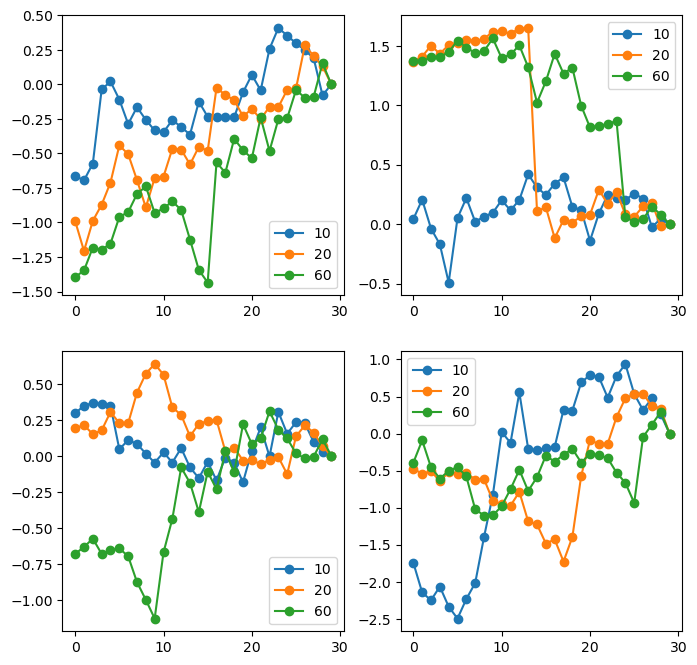

In [10]:
close_idx = np.where(data_generator.columns_order == "close")[0][0]
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(fig.axes):
    for interval_id, x in enumerate(x_batch_train):
        ax.plot(
            x[i, :, close_idx],
            linestyle="-",
            marker="o",
            label=data_generator.ohlc_intervals[interval_id],
        )
    ax.legend()

We can repeat the same chart without normalization to see the actual closing price values. I use the same seed to easily compare results. Further, the CLOSE value from the last time step is at the same level for all intervals, but it represents the actual value of the price and it is clearly visible that the standard deviation for longer intervals is higher

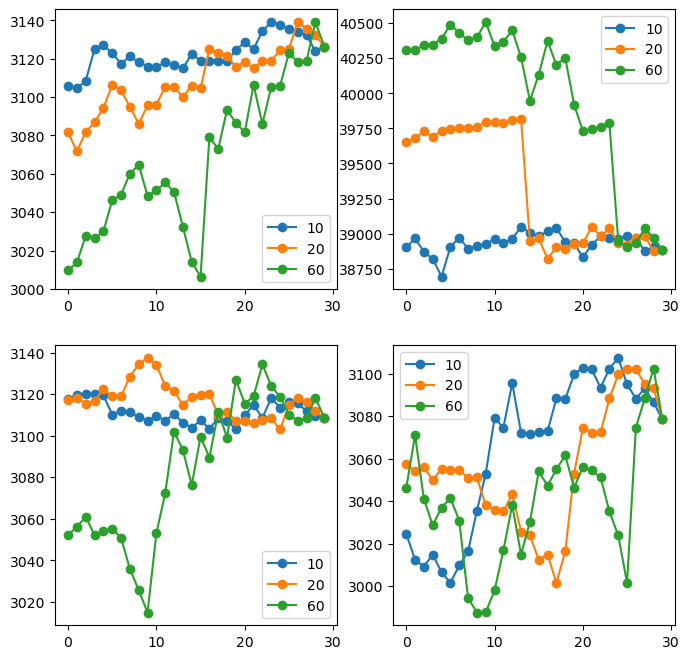

In [11]:
train_gen = data_generator.get_train_generator(
    price_normalize=False, price_normalize_column="close", batch_size=64, seed=123
)
x_batch_train, y_batch_train = next(train_gen)

close_idx = np.where(data_generator.columns_order == "close")[0][0]
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(fig.axes):
    for interval_id, x in enumerate(x_batch_train):
        ax.plot(
            x[i, :, close_idx],
            linestyle="-",
            marker="o",
            label=data_generator.ohlc_intervals[interval_id],
        )
    ax.legend()

If we enlarge one graph, we can also observe that the individual intervals correctly overlap in the appropriate scale. For example, interval 4 looks like interval 2 squeezed twice in the x-axis. I marked two pairs of yellow and red circles on the graph, which show examples of such overlapping points.

3139.12
3139.12
3118.28
3118.28


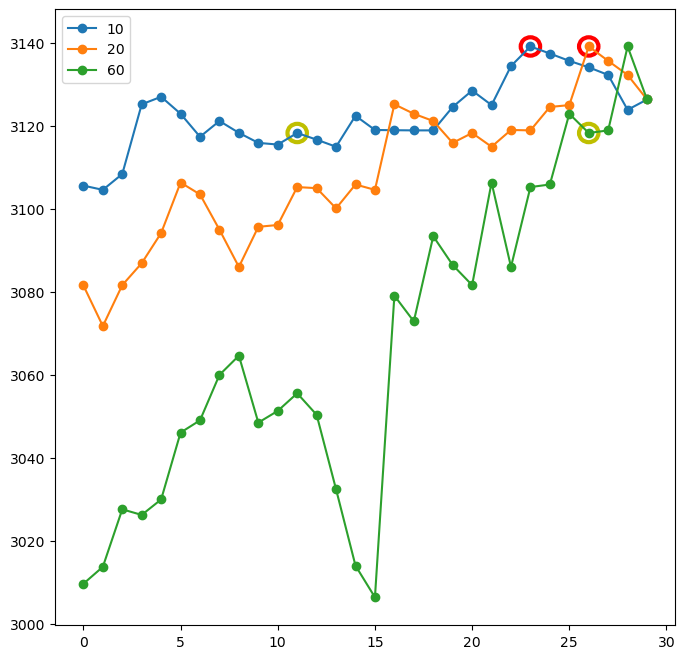

In [12]:
sample_n = 0
for interval_id, x in enumerate(x_batch_train):
    plt.plot(
        x[sample_n, :, 3],
        linestyle="-",
        marker="o",
        label=data_generator.ohlc_intervals[interval_id],
    )
plt.legend()

max_val = max([max(x[sample_n, :, 3]) for x in x_batch_train])
min_val = min([min(x[sample_n, :, 3]) for x in x_batch_train])
aspect = (max_val - min_val) / x_batch_train[0].shape[1]

ax = plt.gca()
x = x_batch_train[0].shape[1] - 1 - 6
y = x_batch_train[0][sample_n, :, 3][-1 - 6]
print(y)
circle1 = Ellipse((x, y), 1, aspect, color="r", fill=False, linewidth=3)
ax.add_patch(circle1)
x = x_batch_train[1].shape[1] - 1 - 3
y = x_batch_train[1][sample_n, :, 3][-1 - 3]
print(y)
circle2 = Ellipse((x, y), 1, aspect, color="r", fill=False, linewidth=3)
ax.add_patch(circle2)

x = x_batch_train[0].shape[1] - 1 - 18
y = x_batch_train[0][sample_n, :, 3][-1 - 18]
print(y)
circle1 = Ellipse((x, y), 1, aspect, color="y", fill=False, linewidth=3)
ax.add_patch(circle1)
x = x_batch_train[2].shape[1] - 1 - 3
y = x_batch_train[2][sample_n, :, 3][-1 - 3]
print(y)
circle2 = Ellipse((x, y), 1, aspect, color="y", fill=False, linewidth=3)
ax.add_patch(circle2)

It remains a matter of seeing what the y-values ​​look like

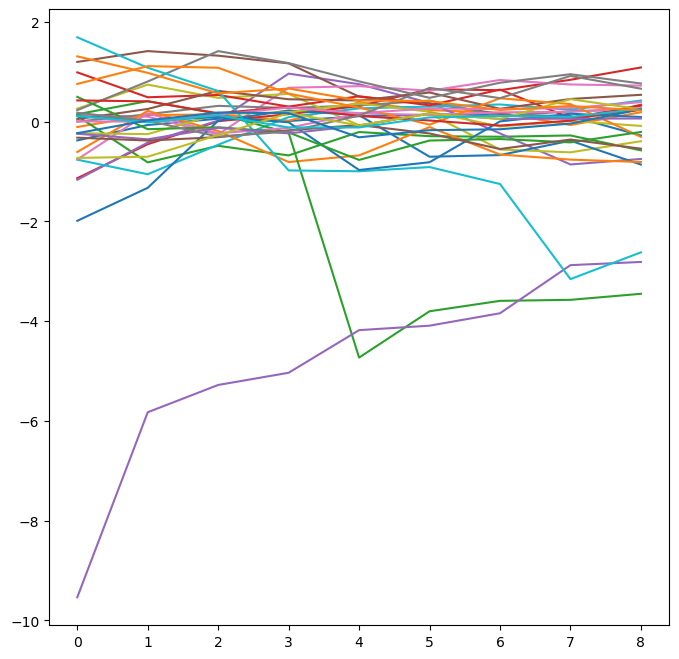

In [13]:
batch_size = 32
data_generator = DataGenerator(
    metadata="metadata.pkl", arrays="arrays.npz", y_standarize=True
)
train_gen = data_generator.get_train_generator(
    price_normalize="pct_change",
    price_normalize_column="close",
    batch_size=batch_size,
    seed=123,
)
x_batch_train, y_batch_train = next(train_gen)

for i in range(batch_size):
    plt.plot(y_batch_train[i])

Since we normalize each y independently, the result presented in this way can and will be easy for the estimating algorithm, but it is illegible. We can disable standardization.

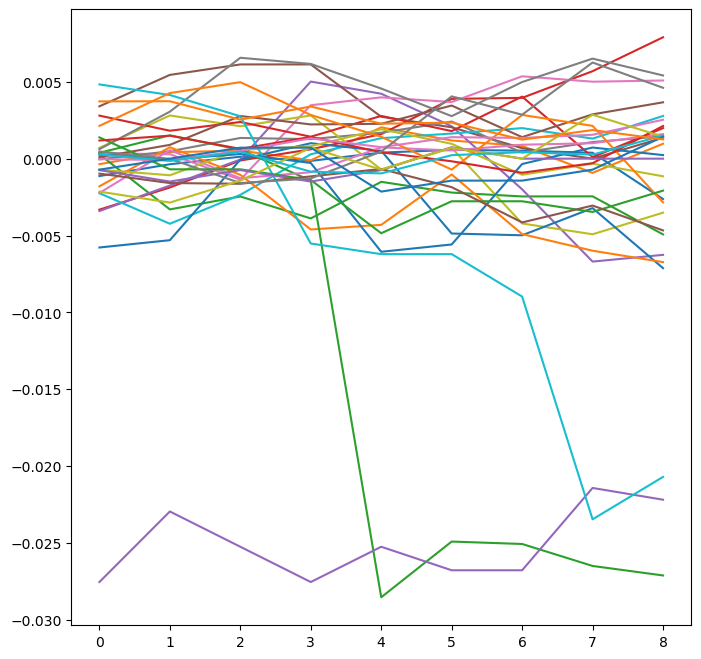

In [14]:
batch_size = 32
data_generator = DataGenerator(
    metadata="metadata.pkl", arrays="arrays.npz", y_standarize=False
)
train_gen = data_generator.get_train_generator(
    price_normalize="pct_change",
    price_normalize_column="close",
    batch_size=batch_size,
    seed=123,
)
x_batch_train, y_batch_train = next(train_gen)

for i in range(batch_size):
    plt.plot(y_batch_train[i])

The default representation for Y is the percentage change for the next 10 time steps. Without normalization, we can clearly see that with each subsequent time step, the variance of the Y value increases, which is predictable.

What is to be treated as Y is very arbitrary, by giving a properly prepared function, we can freely create what the predicted value of Y should be. In the example below, I implement a function that will present unchanged future CLOSE values ​​as Y. Thanks to this, we will be able to easily check whether the data is consistent with the data contained in input X

In [15]:
def raw_future_value(array, columns_order, seq_len, future_column, future_steps):
    future = array[:, np.where(columns_order == future_column)[0][0]]
    future = shift(future, -future_steps - seq_len + 1)

    return future, future_steps

I start indexing from 0, so that the first Y value will be equal to the last X value, normally it doesn't make sense, but thanks to this we will check if our data generation is correct

In [16]:
column = "close"
y_functions = [
    (
        f"raw_future_value_{i}",
        partial(raw_future_value, future_column=column, future_steps=i),
    )
    for i in range(0, 10)
]

In [17]:
print(y_functions[0])

('raw_future_value_0', functools.partial(<function raw_future_value at 0x7fcf13f4d430>, future_column='close', future_steps=0))


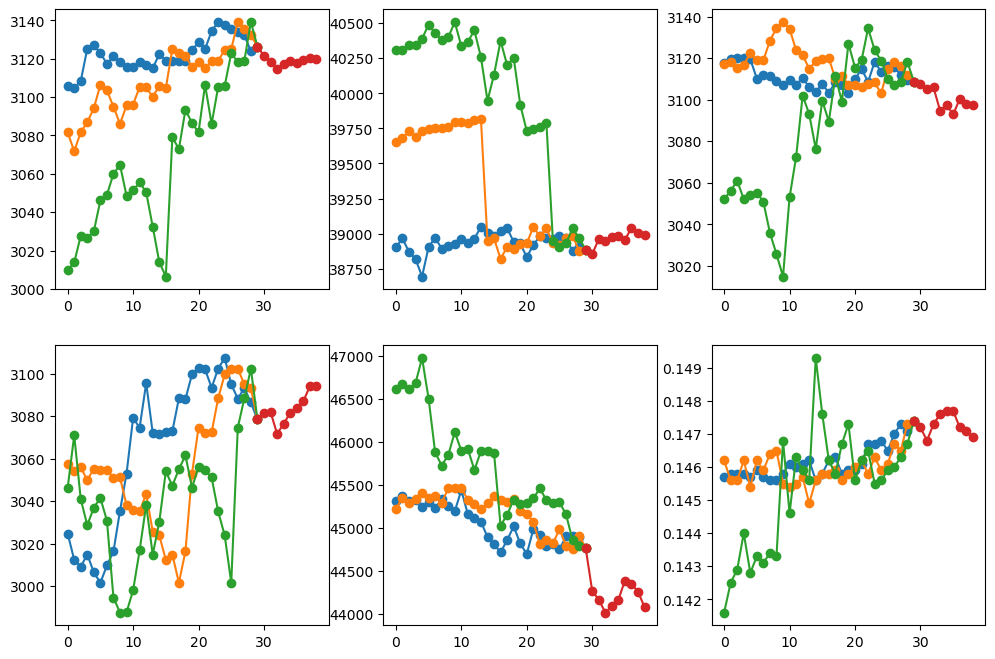

In [18]:
batch_size = 32
data_generator = DataGenerator(
    metadata="metadata.pkl",
    arrays="arrays.npz",
    y_standarize=False,
    y_funcs=y_functions,
)
train_gen = data_generator.get_train_generator(
    price_normalize=False, batch_size=batch_size, seed=123
)
x_batch_train, y_batch_train = next(train_gen)


close_idx = np.where(data_generator.columns_order == "close")[0][0]
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

start_step = x_batch_train[0].shape[1] - 1
end_step = start_step + len(y_batch_train[i])
for i, ax in enumerate(fig.axes):
    for interval_id, x in enumerate(x_batch_train):
        ax.plot(x[i, :, close_idx], linestyle="-", marker="o")
    ax.plot(
        [i for i in range(start_step, end_step)],
        y_batch_train[i],
        linestyle="-",
        marker="o",
    )

Y values ​​are determined correctly